# Random trading strategy example

This dummy example demonstrates how to backtest a simple random trading strategy
using synthetic data generated in the script.
The price series is a random walk with a drift of 0.1 and initial price 1000.

The strategy randomly buys or sells an instrument with a probability of 1%.
Buy and sell orders use the same price series, implying a spread of 0.
Each trade is executed at a fee of 0.1%.
For the sake of illustration, only 75% of the order quantity is filled.

The account equity and drawdowns are collected for every hour
and plotted at the end using the Plots package.

In [1]:
using Fastback
using Dates
using Random

# set RNG seed for reproducibility
Random.seed!(42);

# generate synthetic price series
N = 2_000;
prices = 1000.0 .+ cumsum(randn(N) .+ 0.1);
dts = map(x -> DateTime(2020, 1, 1) + Hour(x), 0:N);

# define instrument
DUMMY = Instrument(1, Symbol("DUMMY"));
instruments = [DUMMY];

# create trading account with 10,000 start capital
acc = Account{Nothing}(instruments, 10_000.0);

# data collector for account equity and drawdowns (sampling every hour)
collect_equity, equity_data = periodic_collector(Float64, Hour(1));
collect_drawdown, drawdown_data = drawdown_collector(DrawdownMode.Percentage, Hour(1));

# loop over price series
for (dt, price) in zip(dts, prices)
    # randomly trade with 1% probability
    if rand() < 0.01
        quantity = rand() > 0.4 ? 1.0 : -1.0
        order = Order(oid!(acc), DUMMY, dt, price, quantity)
        fill_order!(acc, order, dt, price; fill_quantity=0.75order.quantity, fee_pct=0.001)
    end

    # update position and account P&L
    update_pnl!(acc, DUMMY, price)

    # collect data for plotting
    collect_equity(dt, acc.equity)
    collect_drawdown(dt, acc.equity)
end

# print account statistics
show(acc)


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ ACCOUNT SUMMARY ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Balance:         10123.98 (initial 10000.00)
Equity:          10244.09 (+2.4%)
Open positions:  1
┌────────┬──────┬────────────┬────────┐
│ Symbol │  Qty │ Avg. price │    P&L │
├────────┼──────┼────────────┼────────┤
│  DUMMY │ 3.25 │    1086.99 │ 120.11 │
└────────┴──────┴────────────┴────────┘
Trades:          23
┌─────┬────────┬───────────────────────────┬──────────┬─────────────┬────────────┬──────────────┬──────┐
│ Seq │ Symbol │                      Date │ Fill qty │ Remain. qty │ Fill price │ Realized P&L │  Fee │
├─────┼────────┼───────────────────────────┼──────────┼─────────────┼────────────┼──────────────┼──────┤
│   1 │  DUMMY │ 2020-01-01 03:00:00 +0 ms │     0.75 │        0.25 │     999.66 │        -0.75 │ 0.75 │
│   2 │  DUMMY │ 2020-01-05 02:00:00 +0 ms │     0.75 │        0.25 │    1004.04 │        -0.75 │ 0.75 │
│   3 │  DUMMY │ 2020-01-07 18:00:00 +0 ms │     0.75 │        0.25 │    100

### Plot account equity curve

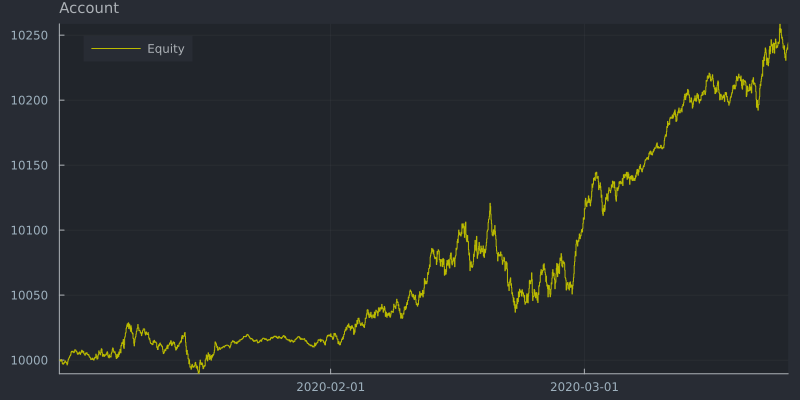

In [2]:
using Plots, Printf
theme(:juno; titlelocation=:left, titlefontsize=10, widen=false, fg_legend=:false)

# plot equity curve
plot(dates(equity_data), values(equity_data);
    title="Account",
    label="Equity",
    linetype=:steppost,
    yformatter=:plain,
    size=(800, 400),
    color="#BBBB00")

### Plot account equity drawdown curve

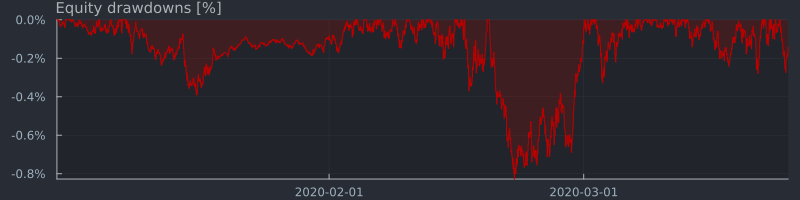

In [3]:
# plot drawdown curve
plot(dates(drawdown_data), 100values(drawdown_data);
    title="Equity drawdowns [%]",
    legend=false,
    linetype=:steppost,
    color="#BB0000",
    yformatter=y -> @sprintf("%.1f%%", y),
    size=(800, 200),
    fill=(0, "#BB000033"))